In [1]:
suppressPackageStartupMessages({
library(dplyr)
library(Seurat)
library(ggplot2)
library(org.Mm.eg.db)
library(EnsDb.Mmusculus.v79)
library(TxDb.Mmusculus.UCSC.mm10.ensGene)
library(tibble)
library(reshape2)
library(viridis)
library(ggpubr)
library(data.table)
})

In [2]:
# Define functions

# Set dplyr as default function for select, filter, and rename
select <- dplyr::select
filter <- dplyr::filter
rename <- dplyr::rename

# Pdf exporting function to maintain naming scheme for filenames
make_pdf <- function(object, filename, w, h){
    out_name <- paste0(format(Sys.Date(), "%y%m%d"),"_",filename,".pdf")
    pdf(out_name, width=w, height=h)
        plot(object)
    dev.off()
}

In [3]:
# Set working directory
setwd("/staging/leuven/stg_00041/Ryan/RA004_XHetDel/beatrice_data/")

In [4]:
# Define colors
myPalette <- list("#77270d", "#ee8866", "#d6c941", "#eedd88", "#aaaa00", "#4ed641", "#44bb99", "#41d6c9", "#414ed6", "#77aadd", "#AC8CC1","#ffaabb")
names(myPalette) <- c("bold_red", "red", "bold_yellow", "yellow", "bold_green", "green", "bold_cyan", "cyan", "bold_blue", "blue", "bold_magenta", "magenta")

# XX            # 4ed641 # green
# XCastOMus     # 77A9DB # blue
# XMusOCast     # EE8766 # red
# XMusY         # EEDD88 # yellow
# Deletion 1    # F6A8BA # magenta
# Deletion 2    # 44BC99 # bold_cyan
# Deletion 3    # AC8CC1 # bold_magenta

In [5]:
# Generate metadata tables
gene_metadata <- left_join(
                 AnnotationDbi::select(EnsDb.Mmusculus.v79,
                   keys=keys(EnsDb.Mmusculus.v79, keytype="GENEID"),
                   columns=c("SYMBOL","GENESEQSTART", "GENESEQEND"),
                   keytype="GENEID"),
                AnnotationDbi::select(TxDb.Mmusculus.UCSC.mm10.ensGene,
                   keys=keys(TxDb.Mmusculus.UCSC.mm10.ensGene, keytype="GENEID"), 
                   column="CDSCHROM",
                   keytype="GENEID"),
                by="GENEID"
            )

'select()' returned 1:1 mapping between keys and columns



In [6]:
metadata <- data.frame(seq_id=c("I21.1615.01", # A, A
                                "I21.1615.02", # A, A
                                "I21.1615.03", # B1ver1, B
                                "I21.1615.04", # B1ver2, AB
                                "I21.1615.05", # B2, C
                                "I21.1615.06", # B2, C
                                "I21.1615.07", # B3, D
                                "I21.1615.08", # B3, D
                                "I21.1615.23", # B3XIC, D-XIC
                                "I21.1615.09", # BusR2, F
                                "I21.1615.10", # BusR2, F
                                "I21.1615.11", # C, G
                                "I21.1615.12", # C, G
                                "I21.1615.13", # Reg1, H
                                "I21.1615.14", # Reg1, H
                                "I21.1615.15", # Reg2, I
                                "I21.1615.16", # Reg2, I
                                "I21.1615.17", # Reg3, J
                                "I21.1615.18", # Reg3, J
                                "I21.1615.19", # Reg4, K
                                "I21.1615.20", # Reg4, K
                                "I21.1615.21", # Reg2.4, I-TEL
                                "I21.1615.22", # Reg2.4, I-TEL
                                "I21.1529.01", # XX, XX
                                "I21.1529.02", # XX, XX
                                "I21.1529.05", # Rnf12, Rnf12
                                "I21.1529.06", # Rnf12, Rnf12
                                "I21.1529.21", # B4, E
                                "I21.1529.23", # B4, E
                                "I23.1325.01", # XCastOMus, XCastOMus
                                "I23.1325.02", # XCastOMus, XCastOMus
                                "I23.1325.03", # XMusOCast, XMusOCast
                                "I23.1325.04"  # XMusOCast, XMusOCast
                               ),
                       old_names=c("A","A","B1ver1","B1ver2","B2","B2","B3","B3","B3XIC","BusR2","BusR2","C","C","Reg1","Reg1","Reg2","Reg2","Reg3","Reg3","Reg4","Reg4","Reg2.4","Reg2.4","XX","XX","Rnf12","Rnf12","B4","B4","XCastOMus","XCastOMus","XMusOCast","XMusOCast"),
                       Deletion=c("A","A","B","AB","C","C","D","D","D-XIC","F","F","G","G","H","H","I","I","J","J","K","K","I-TEL","I-TEL","XX","XX","Rnf12","Rnf12","E","E","XCastOMus","XCastOMus","XMusOCast","XMusOCast"),
                       rep=c(1,2,1,1,1,2,1,2,1,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2)) %>%
    mutate(sample=paste0(Deletion, "_", rep))

In [7]:
# Protein IDs were converted to ENSEMBL gene IDs with BioMart https://nov2020.archive.ensembl.org/biomart/martview/
complex_forming_genes <- c("ENSMUSG00000070390","ENSMUSG00000031095","ENSMUSG00000035576","ENSMUSG00000020758","ENSMUSG00000064127","ENSMUSG00000079487","ENSMUSG00000057378","ENSMUSG00000040720","ENSMUSG00000072980","ENSMUSG00000026768","ENSMUSG00000051747","ENSMUSG00000068394","ENSMUSG00000059995","ENSMUSG00000007880","ENSMUSG00000039219","ENSMUSG00000010453","ENSMUSG00000033769","ENSMUSG00000041445","ENSMUSG00000020916","ENSMUSG00000024897","ENSMUSG00000038102","ENSMUSG00000069272","ENSMUSG00000071478","ENSMUSG00000069270","ENSMUSG00000071516","ENSMUSG00000061615","ENSMUSG00000069309","ENSMUSG00000094248","ENSMUSG00000094777","ENSMUSG00000069301","ENSMUSG00000038770","ENSMUSG00000021057","ENSMUSG00000028001","ENSMUSG00000024169","ENSMUSG00000030592","ENSMUSG00000071226","ENSMUSG00000021313","ENSMUSG00000022000","ENSMUSG00000033237","ENSMUSG00000074818","ENSMUSG00000006005","ENSMUSG00000048118","ENSMUSG00000054051","ENSMUSG00000070808","ENSMUSG00000026509","ENSMUSG00000024381","ENSMUSG00000013663","ENSMUSG00000030814","ENSMUSG00000063727","ENSMUSG00000057789","ENSMUSG00000022324","ENSMUSG00000029238","ENSMUSG00000032855","ENSMUSG00000028249","ENSMUSG00000028800","ENSMUSG00000031059","ENSMUSG00000020668","ENSMUSG00000004264","ENSMUSG00000031921","ENSMUSG00000028339","ENSMUSG00000029177","ENSMUSG00000034462","ENSMUSG00000020792","ENSMUSG00000027782","ENSMUSG00000021929","ENSMUSG00000003731","ENSMUSG00000024942","ENSMUSG00000029763","ENSMUSG00000028926","ENSMUSG00000029469","ENSMUSG00000009090","ENSMUSG00000020471","ENSMUSG00000045948","ENSMUSG00000016427","ENSMUSG00000020583","ENSMUSG00000090071","ENSMUSG00000050675","ENSMUSG00000059363","ENSMUSG00000037772","ENSMUSG00000020893","ENSMUSG00000030165","ENSMUSG00000028757","ENSMUSG00000020198","ENSMUSG00000039231","ENSMUSG00000020689","ENSMUSG00000022809","ENSMUSG00000027381","ENSMUSG00000037935","ENSMUSG00000067713","ENSMUSG00000020974","ENSMUSG00000028847","ENSMUSG00000090247","ENSMUSG00000060636","ENSMUSG00000020897","ENSMUSG00000002814","ENSMUSG00000017716","ENSMUSG00000016758","ENSMUSG00000028957","ENSMUSG00000021611","ENSMUSG00000031819","ENSMUSG00000026196","ENSMUSG00000007877","ENSMUSG00000020722","ENSMUSG00000031012","ENSMUSG00000030054","ENSMUSG00000026837","ENSMUSG00000035021","ENSMUSG00000013415","ENSMUSG00000027012","ENSMUSG00000004221","ENSMUSG00000024947","ENSMUSG00000106695","ENSMUSG00000000142","ENSMUSG00000031609","ENSMUSG00000035086","ENSMUSG00000091512","ENSMUSG00000031660","ENSMUSG00000030528","ENSMUSG00000020331","ENSMUSG00000021730","ENSMUSG00000028051","ENSMUSG00000026761","ENSMUSG00000045867","ENSMUSG00000019979","ENSMUSG00000003872","ENSMUSG00000027162","ENSMUSG00000026029","ENSMUSG00000064370","ENSMUSG00000021250","ENSMUSG00000022346","ENSMUSG00000053977","ENSMUSG00000031502","ENSMUSG00000002900","ENSMUSG00000064341","ENSMUSG00000064345","ENSMUSG00000064360","ENSMUSG00000065947","ENSMUSG00000064363","ENSMUSG00000064367","ENSMUSG00000064368","ENSMUSG00000046834","ENSMUSG00000052217","ENSMUSG00000024620","ENSMUSG00000052684","ENSMUSG00000023043","ENSMUSG00000055609","ENSMUSG00000021822","ENSMUSG00000019982","ENSMUSG00000032231","ENSMUSG00000030978","ENSMUSG00000021270","ENSMUSG00000003549","ENSMUSG00000026043","ENSMUSG00000031503","ENSMUSG00000041959","ENSMUSG00000022982","ENSMUSG00000025809","ENSMUSG00000025371","ENSMUSG00000037894","ENSMUSG00000024109","ENSMUSG00000113902","ENSMUSG00000053044","ENSMUSG00000057329","ENSMUSG00000005397","ENSMUSG00000021939","ENSMUSG00000022884","ENSMUSG00000069268","ENSMUSG00000094338","ENSMUSG00000095217","ENSMUSG00000069307","ENSMUSG00000069303","ENSMUSG00000069300","ENSMUSG00000001506","ENSMUSG00000020649","ENSMUSG00000031538","ENSMUSG00000037992","ENSMUSG00000019942","ENSMUSG00000023944","ENSMUSG00000049382","ENSMUSG00000001128","ENSMUSG00000000555","ENSMUSG00000020277","ENSMUSG00000062647","ENSMUSG00000022105","ENSMUSG00000026576","ENSMUSG00000036905","ENSMUSG00000046364","ENSMUSG00000037563","ENSMUSG00000043716","ENSMUSG00000032518","ENSMUSG00000067274","ENSMUSG00000071076","ENSMUSG00000110974","ENSMUSG00000068220","ENSMUSG00000020428","ENSMUSG00000060279","ENSMUSG00000002957","ENSMUSG00000028645","ENSMUSG00000027342","ENSMUSG00000027931","ENSMUSG00000020592","ENSMUSG00000091898","ENSMUSG00000032796","ENSMUSG00000074129","ENSMUSG00000021665","ENSMUSG00000025395","ENSMUSG00000015290","ENSMUSG00000020436","ENSMUSG00000031731","ENSMUSG00000029054","ENSMUSG00000039639","ENSMUSG00000023994","ENSMUSG00000115906","ENSMUSG00000030830","ENSMUSG00000027187","ENSMUSG00000041431","ENSMUSG00000041859","ENSMUSG00000056174","ENSMUSG00000070348","ENSMUSG00000044533","ENSMUSG00000001281","ENSMUSG00000000560","ENSMUSG00000031343","ENSMUSG00000030435","ENSMUSG00000029231","ENSMUSG00000056054","ENSMUSG00000026187","ENSMUSG00000060036","ENSMUSG00000027248","ENSMUSG00000027985","ENSMUSG00000056501","ENSMUSG00000022483","ENSMUSG00000059436","ENSMUSG00000015846","ENSMUSG00000039656","ENSMUSG00000018395","ENSMUSG00000014767","ENSMUSG00000022283","ENSMUSG00000025232","ENSMUSG00000025888","ENSMUSG00000020826","ENSMUSG00000029863","ENSMUSG00000017344","ENSMUSG00000032218","ENSMUSG00000000184","ENSMUSG00000034165","ENSMUSG00000006728","ENSMUSG00000056071","ENSMUSG00000006678","ENSMUSG00000026134","ENSMUSG00000024833","ENSMUSG00000059003","ENSMUSG00000026959","ENSMUSG00000046223","ENSMUSG00000031299","ENSMUSG00000041695","ENSMUSG00000003033","ENSMUSG00000025408","ENSMUSG00000032193","ENSMUSG00000038900","ENSMUSG00000059070","ENSMUSG00000021779","ENSMUSG00000001435","ENSMUSG00000030432","ENSMUSG00000015579","ENSMUSG00000024151","ENSMUSG00000027087","ENSMUSG00000022391","ENSMUSG00000009907","ENSMUSG00000031201","ENSMUSG00000053110","ENSMUSG00000032116","ENSMUSG00000032553","ENSMUSG00000025407","ENSMUSG00000033065","ENSMUSG00000029614","ENSMUSG00000048758","ENSMUSG00000007892","ENSMUSG00000058558","ENSMUSG00000000740","ENSMUSG00000022479","ENSMUSG00000070880","ENSMUSG00000026787","ENSMUSG00000021816","ENSMUSG00000022092","ENSMUSG00000032034","ENSMUSG00000017146","ENSMUSG00000035458","ENSMUSG00000029253","ENSMUSG00000028969","ENSMUSG00000022673","ENSMUSG00000005410","ENSMUSG00000026414","ENSMUSG00000031449","ENSMUSG00000047215","ENSMUSG00000092074","ENSMUSG00000096255","ENSMUSG00000000579","ENSMUSG00000095677","ENSMUSG00000040613","ENSMUSG00000040533","ENSMUSG00000027715","ENSMUSG00000021103","ENSMUSG00000066878","ENSMUSG00000018362","ENSMUSG00000038644","ENSMUSG00000021606","ENSMUSG00000034957","ENSMUSG00000038975","ENSMUSG00000005370","ENSMUSG00000050761","ENSMUSG00000034362","ENSMUSG00000018983","ENSMUSG00000017264","ENSMUSG00000003458","ENSMUSG00000054312","ENSMUSG00000039680","ENSMUSG00000021221","ENSMUSG00000036678","ENSMUSG00000040034","ENSMUSG00000116037","ENSMUSG00000014418","ENSMUSG00000042548","ENSMUSG00000030079","ENSMUSG00000039703","ENSMUSG00000029580","ENSMUSG00000062270","ENSMUSG00000059796","ENSMUSG00000028234","ENSMUSG00000038583","ENSMUSG00000074781","ENSMUSG00000036372","ENSMUSG00000048100","ENSMUSG00000060938","ENSMUSG00000028609","ENSMUSG00000063316","ENSMUSG00000046330","ENSMUSG00000022174","ENSMUSG00000048895","ENSMUSG00000026917","ENSMUSG00000004849","ENSMUSG00000061477","ENSMUSG00000047675","ENSMUSG00000008683","ENSMUSG00000024608","ENSMUSG00000049517","ENSMUSG00000008668","ENSMUSG00000034892","ENSMUSG00000003429","ENSMUSG00000090862","ENSMUSG00000047459","ENSMUSG00000031320","ENSMUSG00000045128","ENSMUSG00000008036","ENSMUSG00000058546","ENSMUSG00000028495","ENSMUSG00000091405","ENSMUSG00000060981","ENSMUSG00000069274","ENSMUSG00000061482","ENSMUSG00000060678","ENSMUSG00000067455","ENSMUSG00000064288","ENSMUSG00000069266","ENSMUSG00000060093","ENSMUSG00000069306","ENSMUSG00000069305","ENSMUSG00000060639","ENSMUSG00000096010","ENSMUSG00000010803","ENSMUSG00000071415","ENSMUSG00000063457","ENSMUSG00000025290","ENSMUSG00000009927","ENSMUSG00000025362","ENSMUSG00000067288","ENSMUSG00000022400","ENSMUSG00000058600","ENSMUSG00000079641","ENSMUSG00000063694","ENSMUSG00000058927","ENSMUSG00000073702","ENSMUSG00000030744","ENSMUSG00000057841","ENSMUSG00000003970","ENSMUSG00000093674","ENSMUSG00000028639","ENSMUSG00000020460","ENSMUSG00000068240","ENSMUSG00000090137","ENSMUSG00000015656","ENSMUSG00000028156","ENSMUSG00000033676","ENSMUSG00000022285","ENSMUSG00000007653","ENSMUSG00000020248","ENSMUSG00000009013","ENSMUSG00000026824","ENSMUSG00000061787","ENSMUSG00000015120","ENSMUSG00000052146","ENSMUSG00000028161","ENSMUSG00000038845","ENSMUSG00000099517","ENSMUSG00000101355","ENSMUSG00000069265","ENSMUSG00000101972","ENSMUSG00000001440","ENSMUSG00000026585","ENSMUSG00000025271","ENSMUSG00000067199","ENSMUSG00000031681","ENSMUSG00000089682","ENSMUSG00000032897","ENSMUSG00000005262","ENSMUSG00000020647","ENSMUSG00000025925","ENSMUSG00000002010","ENSMUSG00000004446","ENSMUSG00000023027","ENSMUSG00000049751","ENSMUSG00000079435","ENSMUSG00000022841","ENSMUSG00000017404","ENSMUSG00000081058","ENSMUSG00000093769","ENSMUSG00000074403","ENSMUSG00000100210","ENSMUSG00000069273","ENSMUSG00000099583","ENSMUSG00000069310","ENSMUSG00000069267","ENSMUSG00000060499","ENSMUSG00000038612","ENSMUSG00000002870","ENSMUSG00000026355","ENSMUSG00000022672","ENSMUSG00000028081","ENSMUSG00000025358","ENSMUSG00000009545","ENSMUSG00000004642","ENSMUSG00000030697","ENSMUSG00000024515","ENSMUSG00000023051","ENSMUSG00000030652","ENSMUSG00000032481","ENSMUSG00000020038","ENSMUSG00000067614","ENSMUSG00000019846","ENSMUSG00000041147","ENSMUSG00000036887","ENSMUSG00000025508","ENSMUSG00000063882","ENSMUSG00000023951","ENSMUSG00000068196","ENSMUSG00000021264","ENSMUSG00000020734","ENSMUSG00000025958","ENSMUSG00000029661","ENSMUSG00000051331","ENSMUSG00000028452","ENSMUSG00000036896","ENSMUSG00000006932","ENSMUSG00000020241","ENSMUSG00000069089","ENSMUSG00000023885","ENSMUSG00000002771","ENSMUSG00000059412","ENSMUSG00000001119","ENSMUSG00000039462","ENSMUSG00000028047","ENSMUSG00000060798","ENSMUSG00000116357","ENSMUSG00000042406","ENSMUSG00000025064","ENSMUSG00000003873","ENSMUSG00000027323","ENSMUSG00000038482","ENSMUSG00000027067","ENSMUSG00000116526","ENSMUSG00000034848","ENSMUSG00000025321","ENSMUSG00000037185","ENSMUSG00000026141","ENSMUSG00000048402","ENSMUSG00000034292","ENSMUSG00000003119","ENSMUSG00000063884","ENSMUSG00000069830","ENSMUSG00000057177","ENSMUSG00000026609","ENSMUSG00000068794","ENSMUSG00000040187","ENSMUSG00000028863","ENSMUSG00000028197","ENSMUSG00000024687","ENSMUSG00000049562","ENSMUSG00000008140","ENSMUSG00000024349","ENSMUSG00000001445","ENSMUSG00000031446","ENSMUSG00000002658","ENSMUSG00000041126","ENSMUSG00000021711","ENSMUSG00000036672","ENSMUSG00000032187","ENSMUSG00000061244","ENSMUSG00000041215","ENSMUSG00000038544","ENSMUSG00000047921","ENSMUSG00000006335","ENSMUSG00000024740","ENSMUSG00000012076","ENSMUSG00000026708","ENSMUSG00000039623","ENSMUSG00000026042","ENSMUSG00000005233","ENSMUSG00000020743","ENSMUSG00000042015","ENSMUSG00000041471","ENSMUSG00000073471","ENSMUSG00000037890","ENSMUSG00000031820","ENSMUSG00000028114","ENSMUSG00000071014","ENSMUSG00000049323","ENSMUSG00000034560","ENSMUSG00000033862","ENSMUSG00000037991","ENSMUSG00000057649","ENSMUSG00000047146","ENSMUSG00000075266","ENSMUSG00000025645","ENSMUSG00000011658","ENSMUSG00000028330","ENSMUSG00000070369","ENSMUSG00000006464","ENSMUSG00000042284","ENSMUSG00000027829","ENSMUSG00000064128","ENSMUSG00000073436","ENSMUSG00000042506","ENSMUSG00000038000","ENSMUSG00000050697","ENSMUSG00000025782","ENSMUSG00000022191","ENSMUSG00000049299","ENSMUSG00000044795","ENSMUSG00000045672","ENSMUSG00000020519","ENSMUSG00000020898","ENSMUSG00000038909","ENSMUSG00000034297","ENSMUSG00000034329","ENSMUSG00000057667","ENSMUSG00000052595","ENSMUSG00000042557","ENSMUSG00000027544","ENSMUSG00000060601","ENSMUSG00000000568","ENSMUSG00000019899","ENSMUSG00000005947","ENSMUSG00000023964","ENSMUSG00000042453","ENSMUSG00000032332","ENSMUSG00000021408","ENSMUSG00000026037","ENSMUSG00000022905","ENSMUSG00000057236","ENSMUSG00000031353","ENSMUSG00000015647","ENSMUSG00000001105","ENSMUSG00000005886","ENSMUSG00000026641","ENSMUSG00000019471","ENSMUSG00000026639","ENSMUSG00000024826","ENSMUSG00000031077","ENSMUSG00000031386","ENSMUSG00000031928","ENSMUSG00000015994","ENSMUSG00000027966","ENSMUSG00000052911","ENSMUSG00000024959","ENSMUSG00000025499","ENSMUSG00000027793","ENSMUSG00000002068","ENSMUSG00000021548","ENSMUSG00000023018","ENSMUSG00000027490","ENSMUSG00000021318","ENSMUSG00000031533","ENSMUSG00000027111","ENSMUSG00000096146","ENSMUSG00000027475","ENSMUSG00000045545","ENSMUSG00000029730","ENSMUSG00000031622","ENSMUSG00000024241","ENSMUSG00000015776","ENSMUSG00000037013","ENSMUSG00000036980","ENSMUSG00000032440","ENSMUSG00000026374","ENSMUSG00000024563","ENSMUSG00000028252","ENSMUSG00000015533","ENSMUSG00000001507","ENSMUSG00000008958","ENSMUSG00000017858","ENSMUSG00000033953","ENSMUSG00000028310","ENSMUSG00000109511","ENSMUSG00000025650","ENSMUSG00000024949","ENSMUSG00000106722","ENSMUSG00000040274","ENSMUSG00000025758","ENSMUSG00000116326","ENSMUSG00000058239","ENSMUSG00000007613","ENSMUSG00000024330","ENSMUSG00000027326","ENSMUSG00000040865","ENSMUSG00000041297","ENSMUSG00000066415","ENSMUSG00000023932","ENSMUSG00000042029","ENSMUSG00000025648","ENSMUSG00000037315","ENSMUSG00000039068","ENSMUSG00000034152","ENSMUSG00000047767","ENSMUSG00000030323","ENSMUSG00000045983","ENSMUSG00000039738","ENSMUSG00000041846","ENSMUSG00000059474","ENSMUSG00000028949","ENSMUSG00000038205","ENSMUSG00000002428","ENSMUSG00000025369","ENSMUSG00000035770","ENSMUSG00000052915","ENSMUSG00000063870","ENSMUSG00000028294","ENSMUSG00000022292","ENSMUSG00000033628","ENSMUSG00000031099","ENSMUSG00000074030","ENSMUSG00000024104","ENSMUSG00000042185","ENSMUSG00000050310","ENSMUSG00000000600","ENSMUSG00000038564","ENSMUSG00000025764","ENSMUSG00000034154","ENSMUSG00000032555","ENSMUSG00000020387","ENSMUSG00000052533","ENSMUSG00000048578","ENSMUSG00000006333","ENSMUSG00000058443","ENSMUSG00000008682","ENSMUSG00000062997","ENSMUSG00000078193","ENSMUSG00000041084","ENSMUSG00000002043","ENSMUSG00000020022","ENSMUSG00000032423","ENSMUSG00000045248","ENSMUSG00000054702","ENSMUSG00000021377","ENSMUSG00000027933","ENSMUSG00000040463","ENSMUSG00000028322","ENSMUSG00000027751","ENSMUSG00000039809","ENSMUSG00000018412","ENSMUSG00000001855","ENSMUSG00000027959","ENSMUSG00000031314","ENSMUSG00000001998","ENSMUSG00000066621","ENSMUSG00000039137","ENSMUSG00000055334","ENSMUSG00000044254","ENSMUSG00000047534","ENSMUSG00000022371","ENSMUSG00000046756","ENSMUSG00000055553","ENSMUSG00000030708","ENSMUSG00000021559","ENSMUSG00000041238","ENSMUSG00000028364","ENSMUSG00000026725","ENSMUSG00000033543","ENSMUSG00000037740","ENSMUSG00000021932","ENSMUSG00000035919","ENSMUSG00000036106","ENSMUSG00000026798","ENSMUSG00000006542","ENSMUSG00000024286","ENSMUSG00000026107","ENSMUSG00000029656","ENSMUSG00000052798","ENSMUSG00000047989","ENSMUSG00000055078","ENSMUSG00000028873","ENSMUSG00000024260","ENSMUSG00000036291","ENSMUSG00000032939","ENSMUSG00000004843","ENSMUSG00000039055","ENSMUSG00000024038","ENSMUSG00000024576","ENSMUSG00000041632","ENSMUSG00000028576","ENSMUSG00000038696","ENSMUSG00000038116","ENSMUSG00000040690","ENSMUSG00000074811","ENSMUSG00000025646","ENSMUSG00000028247","ENSMUSG00000066643","ENSMUSG00000098274","ENSMUSG00000035234","ENSMUSG00000022992","ENSMUSG00000066900","ENSMUSG00000021767","ENSMUSG00000028518","ENSMUSG00000056832","ENSMUSG00000008690","ENSMUSG00000042323","ENSMUSG00000063801","ENSMUSG00000031328","ENSMUSG00000034826","ENSMUSG00000109941","ENSMUSG00000020514","ENSMUSG00000032402","ENSMUSG00000024477","ENSMUSG00000015750","ENSMUSG00000038481","ENSMUSG00000024360","ENSMUSG00000032965","ENSMUSG00000015829","ENSMUSG00000039552","ENSMUSG00000020783","ENSMUSG00000030330","ENSMUSG00000069495","ENSMUSG00000026289","ENSMUSG00000032396","ENSMUSG00000021209","ENSMUSG00000034906","ENSMUSG00000027080","ENSMUSG00000025235","ENSMUSG00000021965","ENSMUSG00000022350","ENSMUSG00000020319","ENSMUSG00000031629","ENSMUSG00000025144","ENSMUSG00000027509","ENSMUSG00000032375","ENSMUSG00000078517","ENSMUSG00000039985","ENSMUSG00000024240","ENSMUSG00000057914","ENSMUSG00000037526","ENSMUSG00000046192","ENSMUSG00000040866","ENSMUSG00000040667","ENSMUSG00000050552","ENSMUSG00000034349","ENSMUSG00000028312","ENSMUSG00000034160","ENSMUSG00000036568","ENSMUSG00000029505","ENSMUSG00000024926","ENSMUSG00000018651","ENSMUSG00000036180","ENSMUSG00000028019","ENSMUSG00000027425","ENSMUSG00000026491","ENSMUSG00000036698","ENSMUSG00000019906","ENSMUSG00000020652","ENSMUSG00000047604","ENSMUSG00000027778","ENSMUSG00000033831","ENSMUSG00000043866","ENSMUSG00000035031","ENSMUSG00000031262","ENSMUSG00000031782","ENSMUSG00000046573","ENSMUSG00000035354","ENSMUSG00000061273","ENSMUSG00000021577","ENSMUSG00000037325","ENSMUSG00000033373","ENSMUSG00000020628","ENSMUSG00000020775","ENSMUSG00000042694","ENSMUSG00000037531","ENSMUSG00000000378","ENSMUSG00000059734","ENSMUSG00000052139","ENSMUSG00000078676","ENSMUSG00000053293","ENSMUSG00000024053","ENSMUSG00000021144","ENSMUSG00000063564","ENSMUSG00000049489","ENSMUSG00000038982","ENSMUSG00000018858","ENSMUSG00000062203","ENSMUSG00000067995","ENSMUSG00000039509","ENSMUSG00000048930","ENSMUSG00000059534","ENSMUSG00000021235","ENSMUSG00000034190","ENSMUSG00000003680","ENSMUSG00000016833","ENSMUSG00000031539","ENSMUSG00000015971","ENSMUSG00000079614","ENSMUSG00000025374","ENSMUSG00000019715","ENSMUSG00000033970","ENSMUSG00000059518","ENSMUSG00000114797","ENSMUSG00000063895","ENSMUSG00000003778","ENSMUSG00000029635","ENSMUSG00000014232","ENSMUSG00000036435","ENSMUSG00000020882","ENSMUSG00000020739","ENSMUSG00000032691","ENSMUSG00000021738","ENSMUSG00000026999","ENSMUSG00000039356","ENSMUSG00000028614","ENSMUSG00000002968","ENSMUSG00000031935","ENSMUSG00000015083","ENSMUSG00000033860","ENSMUSG00000061650","ENSMUSG00000035831","ENSMUSG00000032571","ENSMUSG00000021013","ENSMUSG00000024101","ENSMUSG00000033161","ENSMUSG00000044018","ENSMUSG00000023723","ENSMUSG00000098375","ENSMUSG00000025451","ENSMUSG00000028899","ENSMUSG00000027835","ENSMUSG00000060708","ENSMUSG00000031913","ENSMUSG00000039630","ENSMUSG00000111145","ENSMUSG00000029670","ENSMUSG00000069170","ENSMUSG00000042390","ENSMUSG00000052293","ENSMUSG00000078941","ENSMUSG00000024033","ENSMUSG00000027615","ENSMUSG00000025580","ENSMUSG00000025968","ENSMUSG00000004415","ENSMUSG00000037860","ENSMUSG00000033430","ENSMUSG00000068823","ENSMUSG00000029676","ENSMUSG00000013593","ENSMUSG00000028944","ENSMUSG00000038697","ENSMUSG00000029265","ENSMUSG00000057531","ENSMUSG00000037798","ENSMUSG00000027244","ENSMUSG00000030062","ENSMUSG00000037916","ENSMUSG00000024906","ENSMUSG00000031715","ENSMUSG00000015804","ENSMUSG00000002679","ENSMUSG00000034259","ENSMUSG00000029681","ENSMUSG00000033732","ENSMUSG00000028622","ENSMUSG00000000743","ENSMUSG00000020463","ENSMUSG00000061527","ENSMUSG00000027998","ENSMUSG00000078348","ENSMUSG00000020063","ENSMUSG00000016356","ENSMUSG00000012114","ENSMUSG00000055817","ENSMUSG00000035772","ENSMUSG00000032006","ENSMUSG00000018160","ENSMUSG00000020358","ENSMUSG00000000561","ENSMUSG00000022881","ENSMUSG00000002109","ENSMUSG00000038160","ENSMUSG00000009555","ENSMUSG00000021278","ENSMUSG00000078619","ENSMUSG00000024218","ENSMUSG00000063887","ENSMUSG00000029163","ENSMUSG00000017210","ENSMUSG00000042328","ENSMUSG00000030286","ENSMUSG00000024735","ENSMUSG00000037570","ENSMUSG00000026260","ENSMUSG00000032314","ENSMUSG00000026563","ENSMUSG00000021028","ENSMUSG00000109901","ENSMUSG00000038803","ENSMUSG00000028648","ENSMUSG00000031546","ENSMUSG00000049548","ENSMUSG00000035984","ENSMUSG00000002083","ENSMUSG00000029712","ENSMUSG00000080268","ENSMUSG00000024436","ENSMUSG00000027374","ENSMUSG00000021607","ENSMUSG00000034880","ENSMUSG00000024414","ENSMUSG00000024683","ENSMUSG00000028140","ENSMUSG00000032563","ENSMUSG00000029486","ENSMUSG00000026683","ENSMUSG00000022142","ENSMUSG00000020962","ENSMUSG00000030034","ENSMUSG00000021901","ENSMUSG00000023089","ENSMUSG00000023919","ENSMUSG00000033845","ENSMUSG00000002416","ENSMUSG00000062981","ENSMUSG00000028066","ENSMUSG00000079677","ENSMUSG00000034932","ENSMUSG00000049960","ENSMUSG00000020163","ENSMUSG00000030335","ENSMUSG00000019710","ENSMUSG00000053119","ENSMUSG00000024925","ENSMUSG00000030842","ENSMUSG00000030042","ENSMUSG00000030291","ENSMUSG00000007338","ENSMUSG00000022774","ENSMUSG00000030647","ENSMUSG00000044894","ENSMUSG00000014294","ENSMUSG00000028549","ENSMUSG00000115904","ENSMUSG00000035674","ENSMUSG00000068101","ENSMUSG00000040236","ENSMUSG00000009863","ENSMUSG00000022109","ENSMUSG00000063787","ENSMUSG00000022820","ENSMUSG00000031242","ENSMUSG00000034211","ENSMUSG00000024902","ENSMUSG00000021967","ENSMUSG00000027673","ENSMUSG00000038622","ENSMUSG00000022354","ENSMUSG00000029066","ENSMUSG00000057388","ENSMUSG00000052962","ENSMUSG00000036850","ENSMUSG00000106918","ENSMUSG00000079317","ENSMUSG00000039001","ENSMUSG00000036835","ENSMUSG00000027133","ENSMUSG00000019923","ENSMUSG00000020477","ENSMUSG00000047260","ENSMUSG00000043501","ENSMUSG00000032905","ENSMUSG00000031232","ENSMUSG00000037152","ENSMUSG00000022450","ENSMUSG00000026032","ENSMUSG00000020171","ENSMUSG00000030869","ENSMUSG00000020056","ENSMUSG00000020492","ENSMUSG00000025794","ENSMUSG00000033751","ENSMUSG00000033938","ENSMUSG00000058267","ENSMUSG00000061286","ENSMUSG00000001056","ENSMUSG00000062376","ENSMUSG00000022337","ENSMUSG00000033166","ENSMUSG00000031755","ENSMUSG00000057506","ENSMUSG00000027649","ENSMUSG00000024854","ENSMUSG00000097508","ENSMUSG00000035351","ENSMUSG00000052926","ENSMUSG00000038374","ENSMUSG00000029438","ENSMUSG00000041733","ENSMUSG00000028973","ENSMUSG00000021598","ENSMUSG00000020801","ENSMUSG00000000171","ENSMUSG00000032459","ENSMUSG00000059291","ENSMUSG00000075273","ENSMUSG00000040269","ENSMUSG00000040599","ENSMUSG00000028010","ENSMUSG00000026248","ENSMUSG00000031669","ENSMUSG00000027635","ENSMUSG00000025651","ENSMUSG00000107235","ENSMUSG00000027454","ENSMUSG00000027455","ENSMUSG00000066042","ENSMUSG00000036860","ENSMUSG00000021391","ENSMUSG00000058076","ENSMUSG00000020397","ENSMUSG00000022978","ENSMUSG00000012405","ENSMUSG00000063145","ENSMUSG00000118537","ENSMUSG00000053134","ENSMUSG00000031756","ENSMUSG00000040952","ENSMUSG00000027131","ENSMUSG00000078923","ENSMUSG00000021748","ENSMUSG00000074476","ENSMUSG00000073705","ENSMUSG00000024056","ENSMUSG00000029363","ENSMUSG00000021731","ENSMUSG00000025785","ENSMUSG00000022551","ENSMUSG00000020483","ENSMUSG00000022945","ENSMUSG00000016637","ENSMUSG00000018882","ENSMUSG00000010406","ENSMUSG00000044991","ENSMUSG00000014551","ENSMUSG00000024181","ENSMUSG00000025858","ENSMUSG00000030037","ENSMUSG00000023939","ENSMUSG00000087260","ENSMUSG00000030298","ENSMUSG00000024829","ENSMUSG00000022370","ENSMUSG00000030801","ENSMUSG00000062006","ENSMUSG00000005687","ENSMUSG00000020993","ENSMUSG00000022674","ENSMUSG00000029918","ENSMUSG00000030045","ENSMUSG00000009070","ENSMUSG00000035367","ENSMUSG00000021357","ENSMUSG00000031821","ENSMUSG00000029211","ENSMUSG00000063172","ENSMUSG00000025204","ENSMUSG00000024099","ENSMUSG00000032279","ENSMUSG00000045176","ENSMUSG00000002345","ENSMUSG00000068264","ENSMUSG00000029003","ENSMUSG00000027752","ENSMUSG00000002767","ENSMUSG00000027536","ENSMUSG00000020778","ENSMUSG00000060679","ENSMUSG00000026087","ENSMUSG00000025825","ENSMUSG00000028419","ENSMUSG00000006392","ENSMUSG00000041841","ENSMUSG00000038467","ENSMUSG00000018923","ENSMUSG00000032399","ENSMUSG00000030879","ENSMUSG00000026283","ENSMUSG00000037204","ENSMUSG00000042992","ENSMUSG00000021790","ENSMUSG00000023966","ENSMUSG00000030714","ENSMUSG00000007867","ENSMUSG00000023806","ENSMUSG00000034321","ENSMUSG00000007987","ENSMUSG00000027569","ENSMUSG00000002031","ENSMUSG00000039640","ENSMUSG00000033916","ENSMUSG00000026799","ENSMUSG00000031367","ENSMUSG00000022217","ENSMUSG00000030884","ENSMUSG00000030888","ENSMUSG00000003444","ENSMUSG00000035152","ENSMUSG00000027642","ENSMUSG00000032042","ENSMUSG00000000399","ENSMUSG00000020153","ENSMUSG00000028861","ENSMUSG00000015672","ENSMUSG00000024142","ENSMUSG00000026895","ENSMUSG00000065990","ENSMUSG00000024480","ENSMUSG00000040048","ENSMUSG00000005510","ENSMUSG00000111727","ENSMUSG00000003299","ENSMUSG00000004610","ENSMUSG00000055943","ENSMUSG00000030793","ENSMUSG00000022236","ENSMUSG00000023980","ENSMUSG00000030612","ENSMUSG00000022718","ENSMUSG00000106687","ENSMUSG00000060475","ENSMUSG00000068921","ENSMUSG00000036199","ENSMUSG00000003226","ENSMUSG00000025507","ENSMUSG00000032112","ENSMUSG00000063049","ENSMUSG00000025907","ENSMUSG00000021714","ENSMUSG00000031403","ENSMUSG00000000708","ENSMUSG00000020918","ENSMUSG00000027714","ENSMUSG00000008590","ENSMUSG00000040472","ENSMUSG00000028062","ENSMUSG00000004096","ENSMUSG00000018707","ENSMUSG00000009640","ENSMUSG00000016619","ENSMUSG00000020075","ENSMUSG00000038880","ENSMUSG00000022338","ENSMUSG00000020659","ENSMUSG00000022534","ENSMUSG00000053519","ENSMUSG00000006398","ENSMUSG00000025221","ENSMUSG00000029068","ENSMUSG00000057322","ENSMUSG00000028988","ENSMUSG00000040044","ENSMUSG00000019518","ENSMUSG00000021824","ENSMUSG00000022889","ENSMUSG00000068391","ENSMUSG00000026726","ENSMUSG00000028991","ENSMUSG00000024521","ENSMUSG00000062444","ENSMUSG00000015013","ENSMUSG00000034664","ENSMUSG00000002835","ENSMUSG00000011960","ENSMUSG00000030584","ENSMUSG00000030789","ENSMUSG00000045969","ENSMUSG00000030091","ENSMUSG00000045273","ENSMUSG00000022545","ENSMUSG00000056820","ENSMUSG00000020718","ENSMUSG00000067158","ENSMUSG00000079465","ENSMUSG00000029513","ENSMUSG00000026840","ENSMUSG00000005804","ENSMUSG00000031849","ENSMUSG00000051879","ENSMUSG00000031422","ENSMUSG00000092558","ENSMUSG00000032175","ENSMUSG00000071646","ENSMUSG00000068742","ENSMUSG00000051316","ENSMUSG00000058806","ENSMUSG00000052833","ENSMUSG00000059588","ENSMUSG00000028224","ENSMUSG00000024308","ENSMUSG00000034353","ENSMUSG00000055116","ENSMUSG00000003868","ENSMUSG00000002731","ENSMUSG00000029554","ENSMUSG00000030873","ENSMUSG00000000216","ENSMUSG00000024660","ENSMUSG00000032504","ENSMUSG00000021196","ENSMUSG00000023104","ENSMUSG00000001240","ENSMUSG00000041046","ENSMUSG00000018189","ENSMUSG00000029012","ENSMUSG00000024462","ENSMUSG00000024091","ENSMUSG00000022812","ENSMUSG00000032952","ENSMUSG00000066979","ENSMUSG00000007080","ENSMUSG00000031358","ENSMUSG00000048756","ENSMUSG00000020955","ENSMUSG00000000902","ENSMUSG00000025231","ENSMUSG00000026971","ENSMUSG00000040896","ENSMUSG00000060882","ENSMUSG00000051329","ENSMUSG00000002108","ENSMUSG00000029910","ENSMUSG00000052997","ENSMUSG00000027618","ENSMUSG00000028587","ENSMUSG00000041881","ENSMUSG00000024392","ENSMUSG00000040084","ENSMUSG00000021686","ENSMUSG00000021702","ENSMUSG00000000028","ENSMUSG00000028212","ENSMUSG00000001018","ENSMUSG00000002748","ENSMUSG00000035478","ENSMUSG00000024513","ENSMUSG00000027671","ENSMUSG00000022706","ENSMUSG00000022779")

# List of proteins in condensates obtained from https://cd-code.org/condensates
condensate_genes <- c("ENSMUSG00000050089","ENSMUSG00000031144","ENSMUSG00000031149","ENSMUSG00000031167","ENSMUSG00000031007","ENSMUSG00000031010","ENSMUSG00000031012","ENSMUSG00000025037","ENSMUSG00000040147","ENSMUSG00000060090","ENSMUSG00000031059","ENSMUSG00000001924","ENSMUSG00000031065","ENSMUSG00000037217","ENSMUSG00000016319","ENSMUSG00000050379","ENSMUSG00000001986","ENSMUSG00000036932","ENSMUSG00000031119","ENSMUSG00000000838","ENSMUSG00000015214","ENSMUSG00000031343","ENSMUSG00000031347","ENSMUSG00000031375","ENSMUSG00000031376","ENSMUSG00000002010","ENSMUSG00000031391","ENSMUSG00000001964","ENSMUSG00000008682","ENSMUSG00000019087","ENSMUSG00000015291","ENSMUSG00000031402","ENSMUSG00000045103","ENSMUSG00000052372","ENSMUSG00000079508","ENSMUSG00000025656","ENSMUSG00000031207","ENSMUSG00000000881","ENSMUSG00000031302","ENSMUSG00000031311","ENSMUSG00000031320","ENSMUSG00000025525","ENSMUSG00000033578","ENSMUSG00000079435","ENSMUSG00000031425","ENSMUSG00000042425","ENSMUSG00000031432","ENSMUSG00000041688","ENSMUSG00000025262","ENSMUSG00000041133","ENSMUSG00000041115","ENSMUSG00000041633","ENSMUSG00000025658","ENSMUSG00000041020","ENSMUSG00000040990","ENSMUSG00000031299","ENSMUSG00000031292","ENSMUSG00000031342")

# List of escapee genes obtained from Berletch et al., 2015 10.1016/j.dib.2015.10.033
escapee_genes <- c("ENSMUSG00000073294","ENSMUSG00000023279","ENSMUSG00000031144","ENSMUSG00000015340","ENSMUSG00000000787","ENSMUSG00000037369","ENSMUSG00000001128","ENSMUSG00000016534","ENSMUSG00000063785","ENSMUSG00000085396","ENSMUSG00000031375","ENSMUSG00000031328","ENSMUSG00000015291","ENSMUSG00000025666","ENSMUSG00000025058","ENSMUSG00000081044","ENSMUSG00000035150","ENSMUSG00000044206","ENSMUSG00000034311","ENSMUSG00000086503","ENSMUSG00000086370","ENSMUSG00000033965","ENSMUSG00000056537","ENSMUSG00000087174","ENSMUSG00000031226","ENSMUSG00000081793","ENSMUSG00000031246","ENSMUSG00000043384","ENSMUSG00000031425","ENSMUSG00000042595","ENSMUSG00000031438","ENSMUSG00000047045","ENSMUSG00000041718","ENSMUSG00000041353","ENSMUSG00000025332","ENSMUSG00000031299","ENSMUSG00000031373","ENSMUSG00000031342")

In [8]:
gene_metadata <- gene_metadata %>%
    mutate(escapee=case_when(SYMBOL %in% escapee_genes ~ TRUE,
                              TRUE ~ FALSE))

In [9]:
corrected_celltypes <- read.table("/staging/leuven/stg_00041/Ryan/RA004_XHetDel/deep_seq/data/Ryan_Allsop/zUMI_out/240424_corrected_celltype.csv", sep=",")
head(corrected_celltypes)

,Well_cell_line,Cell_type,X_or_A,meanTPM_total,meanTPM_cast,meanTPM_mus,X_ratio,new_cell_type,reanno_bool
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<lgl>
1,J9_XY,XY,X,11.58678,1.0924513,10.494331,9.606223,XMusY,FALSE
2,F9_XY,XY,X,11.17584,0.1984838,10.977353,55.306039,XMusY,FALSE
3,G9_XY,XY,X,14.47623,0.3810971,14.095137,36.985680,XMusY,FALSE
4,A9_XY,XY,X,7.95453,0.0439360,7.910594,180.048113,XMusY,FALSE
5,C9_XY,XY,X,13.02956,0.2408742,12.788691,53.092827,XMusY,FALSE
6,D9_XY,XY,X,12.31933,0.2121996,12.107133,57.055388,XMusY,FALSE


In [10]:
seurat_cast <- readRDS("/staging/leuven/stg_00041/Ryan/RA004_XHetDel/deep_seq/data/Ryan_Allsop/zUMI_out/240424_Cast_seurat_obj.rds")
seurat_mus <- readRDS("/staging/leuven/stg_00041/Ryan/RA004_XHetDel/deep_seq/data/Ryan_Allsop/zUMI_out/240424_Mus_seurat_obj.rds")

In [11]:
seurat_filt <- readRDS("/staging/leuven/stg_00041/Ryan/RA004_XHetDel/deep_seq/data/Ryan_Allsop/zUMI_out/240424_nonallelic_seurat_obj.rds")

In [12]:
cast_melt <- seurat_cast@assays$UMI@counts %>%
    as.data.frame() %>%
    rownames_to_column("gene_id") %>%
    mutate(GENEID=gsub("\\.[0-9]+$", "", .$gene_id)) %>%
    left_join(gene_metadata) %>%
    filter(CDSCHROM %in% c(unlist(lapply(1:19, function(x){paste0("chr",x)})), "chrX", "chrY")) %>%
    mutate(GENELENGTH=GENESEQEND-GENESEQSTART) %>%
    melt(id.vars = c("gene_id", "GENEID", "SYMBOL", "GENESEQSTART", "GENESEQEND", "CDSCHROM", "GENELENGTH", "escapee")) %>%
    select(-gene_id) %>%
    rename(Well_cell_line=variable) %>%
    mutate(Cell_type=gsub(pattern = "[A-Z][0-9]{1,2}_", replacement = "", x=.$Well_cell_line)) %>%
    dplyr::rename(Cast=value)

mus_melt <- seurat_mus@assays$UMI@counts %>%
    as.data.frame() %>%
    rownames_to_column("gene_id") %>%
    mutate(GENEID=gsub("\\.[0-9]+$", "", .$gene_id)) %>%
    left_join(gene_metadata) %>%
    filter(CDSCHROM %in% c(unlist(lapply(1:19, function(x){paste0("chr",x)})), "chrX", "chrY")) %>%
    mutate(GENELENGTH=GENESEQEND-GENESEQSTART) %>%
    melt(id.vars = c("gene_id", "GENEID", "SYMBOL", "GENESEQSTART", "GENESEQEND", "CDSCHROM", "GENELENGTH", "escapee")) %>%
    select(-gene_id) %>%
    rename(Well_cell_line=variable) %>%
    mutate(Cell_type=gsub(pattern = "[A-Z][0-9]{1,2}_", replacement = "", x=.$Well_cell_line)) %>%
    dplyr::rename(Mus=value)

Joining, by = "GENEID"
Warning message in melt(., id.vars = c("gene_id", "GENEID", "SYMBOL", "GENESEQSTART", :
"The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(.). In the next version, this warning will become an error."
Joining, by = "GENEID"
Warning message in melt(., id.vars = c("gene_id", "GENEID", "SYMBOL", "GENESEQSTART", :
"The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(.

In [13]:
counts_melt <- left_join(cast_melt, mus_melt) %>% 
    mutate(total_counts=Cast+Mus) %>%
    mutate(RPK_total=total_counts/GENELENGTH,
           RPK_cast=Cast/GENELENGTH,
           RPK_mus=Mus/GENELENGTH) %>%
    left_join(summarize(group_by(., Well_cell_line),
                        scaling_factor_total=(sum(na.omit(RPK_total))/1e6),
                        scaling_factor_cast=(sum(na.omit(RPK_cast))/1e6),
                        scaling_factor_mus=(sum(na.omit(RPK_mus))/1e6))) %>%
    mutate(TPM_total=RPK_total/scaling_factor_total,
           TPM_cast=RPK_cast/scaling_factor_total,
           TPM_mus=RPK_mus/scaling_factor_total) %>%
    left_join(corrected_celltypes[,c("Well_cell_line", "new_cell_type")]) %>%
    select(-Cell_type) %>%
    rename(Cell_type=new_cell_type)

counts_melt %>% head

Joining, by = c("GENEID", "SYMBOL", "GENESEQSTART", "GENESEQEND", "CDSCHROM", "GENELENGTH", "escapee", "Well_cell_line", "Cell_type")
Joining, by = "Well_cell_line"
Joining, by = "Well_cell_line"


,GENEID,SYMBOL,GENESEQSTART,GENESEQEND,CDSCHROM,GENELENGTH,escapee,Well_cell_line,Cast,Mus,⋯,RPK_total,RPK_cast,RPK_mus,scaling_factor_total,scaling_factor_cast,scaling_factor_mus,TPM_total,TPM_cast,TPM_mus,Cell_type
,<chr>,<chr>,<int>,<int>,<chr>,<int>,<lgl>,<chr>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,ENSMUSG00000000001,Gnai3,108107280,108146146,chr3,38866,FALSE,J9_XY,1,1,⋯,5.145886e-05,2.572943e-05,2.572943e-05,1.136715e-05,5.834961e-06,5.532191e-06,4.5269789,2.263489,2.2634895,XMusY
2,ENSMUSG00000000028,Cdc45,18780447,18811987,chr16,31540,FALSE,J9_XY,0,0,⋯,0.000000e+00,0.000000e+00,0.000000e+00,1.136715e-05,5.834961e-06,5.532191e-06,0.0000000,0.000000,0.0000000,XMusY
3,ENSMUSG00000000037,Scml2,161117193,161258213,chrX,141020,FALSE,J9_XY,0,0,⋯,0.000000e+00,0.000000e+00,0.000000e+00,1.136715e-05,5.834961e-06,5.532191e-06,0.0000000,0.000000,0.0000000,XMusY
4,ENSMUSG00000000056,Narf,121237253,121255856,chr11,18603,FALSE,J9_XY,0,0,⋯,0.000000e+00,0.000000e+00,0.000000e+00,1.136715e-05,5.834961e-06,5.532191e-06,0.0000000,0.000000,0.0000000,XMusY
5,ENSMUSG00000000078,Klf6,5861489,5870393,chr13,8904,FALSE,J9_XY,1,1,⋯,2.246181e-04,1.123091e-04,1.123091e-04,1.136715e-05,5.834961e-06,5.532191e-06,19.7602834,9.880142,9.8801417,XMusY
6,ENSMUSG00000000085,Scmh1,120405281,120530186,chr4,124905,FALSE,J9_XY,0,1,⋯,8.006085e-06,0.000000e+00,8.006085e-06,1.136715e-05,5.834961e-06,5.532191e-06,0.7043175,0.000000,0.7043175,XMusY


In [14]:
total_melt <- seurat_filt@assays$UMI@counts %>%
    as.data.frame() %>% 
    rownames_to_column("gene_id") %>%
    mutate(GENEID=gsub("\\.[0-9]+$", "", .$gene_id)) %>%
    left_join(gene_metadata) %>%
    filter(CDSCHROM %in% c(unlist(lapply(1:19, function(x){paste0("chr",x)})), "chrX", "chrY")) %>%
    mutate(GENELENGTH=GENESEQEND-GENESEQSTART) %>%
    melt(id.vars = c("gene_id", "GENEID", "SYMBOL", "GENESEQSTART", "GENESEQEND", "CDSCHROM", "GENELENGTH")) %>%
    select(-gene_id) %>%
    rename(Well_cell_line=variable) %>%
    mutate(Cell_line=gsub(pattern = "[A-Z][0-9]{1,2}_", replacement = "", x=.$Well_cell_line),
           RPK=value/GENELENGTH) %>%
    left_join(summarize(group_by(., Well_cell_line), scaling_factor=(sum(na.omit(RPK))/1e6))) %>%
    mutate(TPM=RPK/scaling_factor) %>%
    left_join(corrected_celltypes[,c("Well_cell_line", "new_cell_type")]) %>%
    select(-Cell_line) %>%
    rename(Cell_type=new_cell_type)

total_melt %>% head

Joining, by = "GENEID"
Warning message in melt(., id.vars = c("gene_id", "GENEID", "SYMBOL", "GENESEQSTART", :
"The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(.). In the next version, this warning will become an error."
Joining, by = "Well_cell_line"
Joining, by = "Well_cell_line"


,GENEID,SYMBOL,GENESEQSTART,GENESEQEND,CDSCHROM,GENELENGTH,Well_cell_line,value,RPK,scaling_factor,TPM,Cell_type
,<chr>,<chr>,<int>,<int>,<chr>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,ENSMUSG00000000001,Gnai3,108107280,108146146,chr3,38866,J7_XX,20,5.145886e-04,6.295498e-05,8.1739135,XX
2,ENSMUSG00000000028,Cdc45,18780447,18811987,chr16,31540,J7_XX,9,2.853519e-04,6.295498e-05,4.5326346,XX
3,ENSMUSG00000000037,Scml2,161117193,161258213,chrX,141020,J7_XX,2,1.418239e-05,6.295498e-05,0.2252782,XX
4,ENSMUSG00000000056,Narf,121237253,121255856,chr11,18603,J7_XX,0,0.000000e+00,6.295498e-05,0.0000000,XX
5,ENSMUSG00000000058,Cav2,17281185,17289115,chr6,7930,J7_XX,0,0.000000e+00,6.295498e-05,0.0000000,XX
6,ENSMUSG00000000078,Klf6,5861489,5870393,chr13,8904,J7_XX,8,8.984726e-04,6.295498e-05,14.2716677,XX


In [15]:
#protein_up_genes <- c("ENSMUSG00000050029", "ENSMUSG00000002010", "ENSMUSG00000071708", "ENSMUSG00000016308", "ENSMUSG00000031197", "ENSMUSG00000031143", "ENSMUSG00000000355", "ENSMUSG00000071723", "ENSMUSG00000079487", "ENSMUSG00000031065", "ENSMUSG00000079508", "ENSMUSG00000000787", "ENSMUSG00000025626", "ENSMUSG00000031161", "ENSMUSG00000031353", "ENSMUSG00000015291", "ENSMUSG00000031095", "ENSMUSG00000031157", "ENSMUSG00000015668", "ENSMUSG00000031422", "ENSMUSG00000057421", "ENSMUSG00000031134", "ENSMUSG00000031099", "ENSMUSG00000015290", "ENSMUSG00000031256", "ENSMUSG00000008682", "ENSMUSG00000079641", "ENSMUSG00000031207", "ENSMUSG00000067860", "ENSMUSG00000045180", "ENSMUSG00000031278", "ENSMUSG00000031320", "ENSMUSG00000041133", "ENSMUSG00000063785", "ENSMUSG00000025266", "ENSMUSG00000037369", "ENSMUSG00000031299", "ENSMUSG00000031386", "ENSMUSG00000016382", "ENSMUSG00000031328", "ENSMUSG00000031403", "ENSMUSG00000031311", "ENSMUSG00000031167", "ENSMUSG00000064127")
protein_up_genes <- c("UBE2A","PLS3","CUL4B","MED14","MED12","SHROOM2","LAS1L","FLNA","RPL10","KDM6A","RBM3","UBL4A","MSN","PDHA1","GDI1","VBP1","RPS4X","RPL39","IDH3G","SMS","CDK16","GSPT2","RBBP7","HCFC1","DDX3X","ZIC3","UTP14A","SMARCA1","GNL3L","CSTF2","RAP2C","PQBP1","NONO","SMC1A","PDZD11","PHF6","MCTS1","APOO","DKC1","CCDC22","ACSL4","MORF4L2","RLIM","RBMX","HDAC6")

In [16]:
rna_up_genes <- c("ENSMUSG00000000134","ENSMUSG00000000881","ENSMUSG00000001924","ENSMUSG00000002006","ENSMUSG00000006678","ENSMUSG00000016382","ENSMUSG00000023092","ENSMUSG00000025037","ENSMUSG00000025040","ENSMUSG00000025056","ENSMUSG00000025246","ENSMUSG00000025260","ENSMUSG00000025266","ENSMUSG00000025271","ENSMUSG00000025272","ENSMUSG00000025283","ENSMUSG00000025289","ENSMUSG00000025332","ENSMUSG00000025665","ENSMUSG00000025666","ENSMUSG00000031059","ENSMUSG00000031119","ENSMUSG00000031146","ENSMUSG00000031154","ENSMUSG00000031155","ENSMUSG00000031160","ENSMUSG00000031162","ENSMUSG00000031163","ENSMUSG00000031167","ENSMUSG00000031169","ENSMUSG00000031198","ENSMUSG00000031200","ENSMUSG00000031207","ENSMUSG00000031220","ENSMUSG00000031239","ENSMUSG00000031242","ENSMUSG00000031245","ENSMUSG00000031278","ENSMUSG00000031297","ENSMUSG00000031299","ENSMUSG00000031302","ENSMUSG00000031311","ENSMUSG00000031312","ENSMUSG00000031320","ENSMUSG00000031328","ENSMUSG00000031340","ENSMUSG00000031347","ENSMUSG00000031357","ENSMUSG00000031358","ENSMUSG00000031386","ENSMUSG00000031388","ENSMUSG00000031398","ENSMUSG00000031400","ENSMUSG00000031403","ENSMUSG00000032806","ENSMUSG00000033436","ENSMUSG00000033460","ENSMUSG00000033737","ENSMUSG00000033965","ENSMUSG00000034160","ENSMUSG00000034311","ENSMUSG00000034457","ENSMUSG00000035232","ENSMUSG00000035246","ENSMUSG00000035476","ENSMUSG00000035491","ENSMUSG00000036022","ENSMUSG00000036916","ENSMUSG00000037369","ENSMUSG00000039231","ENSMUSG00000040363","ENSMUSG00000040621","ENSMUSG00000041096","ENSMUSG00000041133","ENSMUSG00000041552","ENSMUSG00000041633","ENSMUSG00000041658","ENSMUSG00000041688","ENSMUSG00000041718","ENSMUSG00000042515","ENSMUSG00000042595","ENSMUSG00000042903","ENSMUSG00000044348","ENSMUSG00000044550","ENSMUSG00000045180","ENSMUSG00000045427","ENSMUSG00000046432","ENSMUSG00000046449","ENSMUSG00000046550","ENSMUSG00000047045","ENSMUSG00000048040","ENSMUSG00000048573","ENSMUSG00000049191","ENSMUSG00000049929","ENSMUSG00000050148","ENSMUSG00000051220","ENSMUSG00000052854","ENSMUSG00000056537","ENSMUSG00000058254","ENSMUSG00000059493","ENSMUSG00000061273","ENSMUSG00000062184","ENSMUSG00000063663","ENSMUSG00000063785","ENSMUSG00000064127","ENSMUSG00000067860","ENSMUSG00000067878","ENSMUSG00000068270","ENSMUSG00000073207","ENSMUSG00000073295","ENSMUSG00000079316","ENSMUSG00000079435","ENSMUSG00000089996")

In [18]:
bulk_tpm <- read.table(file = "TPMs.nonallelic.txt", header=TRUE, sep="\t")
protein_fc <- read.table("/staging/leuven/stg_00041/Ryan/RA004_XHetDel/deep_seq/data/Ryan_Allsop/zUMI_out/Counts.allelecorrected.FC.txt", header = TRUE) %>%
    #select(XO_fc, GeneName) %>%
    rename(SYMBOL=GeneName) %>%
    left_join(gene_metadata[,c("GENEID", "SYMBOL")])
colnames(bulk_tpm)[gsub("\\.merged", "", colnames(bulk_tpm)) %in% metadata$seq_id] <- metadata %>% filter(seq_id %in% gsub("\\.merged", "", colnames(bulk_tpm))) %>% .$sample

Joining, by = "SYMBOL"


In [22]:
protein_data <- read.table("/staging/leuven/stg_00041/Ryan/RA004_XHetDel/deep_seq/data/Ryan_Allsop/zUMI_out/Counts.allelecorrected.FC.txt", header = TRUE)
E_genes <- protein_data %>% filter(DelE=="Inside") %>% .$GeneName
K_genes <- protein_data %>% filter(DelK=="Inside") %>% .$GeneName
X1_genes <- protein_data %>% filter(Del1=="Inside") %>% .$GeneName
X2_genes <- protein_data %>% filter(Del2=="Inside") %>% .$GeneName

E_genes
K_genes
X1_genes
X2_genes

[1] "Flna"    "Zfp185"  "Rpl10"   "Emd"     "Hmgb3"   "Ubl4a"   "Bgn"    
 [8] "Brcc3"   "Gdi1"    "Vbp1"    "Mpp1"    "Idh3g"   "G6pdx"   "Hcfc1"  
[15] "Bcap31"  "Ssr4"    "Vma21"   "Dusp9"   "Haus7"   "Fundc2"  "Dkc1"   
[22] "Pdzd4"   "Nsdhl"   "Cetn2"   "Atp6ap1" "Fam50a"  "Mecp2"

[1] "Huwe1"    "Shroom2"  "Lrch2"    "Kdm5c"    "Fgd1"     "Gnl3l"   
 [7] "Phf8"     "Wnk3"     "Hsd17b10" "Smc1a"    "Maged2"

[1] "Cask"     "Ube2a"    "Nkrf"     "Tbc1d25"  "Cul4b"    "Med14"   
 [7] "Tfe3"     "Dock11"   "Ndufb11"  "Stag2"    "Pgrmc1"   "Kdm6a"   
[13] "Rbm3"     "Araf"     "Gpc4"     "Slc25a5"  "Rpl39"    "Ebp"     
[19] "Usp9x"    "Uba1"     "Cdk16"    "Gpkow"    "Ddx3x"    "Utp14a"  
[25] "Maoa"     "Ocrl"     "Smarca1"  "Eras"     "Klhl13"   "Htatsf1" 
[31] "Rap2c"    "Gpc3"     "Bcor"     "Mmgt1"    "Rbmx2"    "Rnf113a1"
[37] "Pqbp1"    "Rbm10"    "Rbm10"    "Atp6ap2"  "Nkap"     "Phf6"    
[43] "Mcts1"    "Praf2"    "Uxt"      "Timm17b"  "Aifm1"    "Hdac6"

[1] "Hmgb3" "Zic3"  "Vma21" "Rbmx"

In [23]:
protein_data %>% head

,GeneName,XO.1,XO.2,XO.3,XY.1,XY.2,XY.3,E.1,E.2,E.3,⋯,Pasque_fc,DelPasque,XO_mean,XY_mean,E_mean,K_mean,X1_mean,X2_mean,Rnf12_mean,Status
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,Cask,697502.8,850265.6,466972.3,955861.1,879985.1,951948.9,663552.81,705623.06,683468.50,⋯,-0.4692824,Del1,19.35720,19.82573,19.38409,19.57943,18.62848,19.09776,19.30191,Other
2,Ube2a,712823.8,660664.6,682194.2,839790.7,671823.6,765680.8,394964.59,315160.22,390534.28,⋯,0.4944838,Del1,19.38622,19.53393,18.48497,18.87263,20.25505,19.76057,18.56866,Up
3,Pls3,3365060.8,3689902.8,3577433.2,7439444.0,6694185.5,8244989.0,2455809.50,2591014.75,3117360.25,⋯,0.1059350,Outside,21.75700,22.83066,21.37591,21.46671,23.06850,22.96257,20.93668,Up
4,Nkrf,3344514.0,3573171.0,3592753.2,3324095.0,2912561.2,2571168.8,5369643.50,4908834.00,4115388.00,⋯,-0.1169228,Del1,21.74036,21.48539,22.19399,22.21892,20.72120,20.83812,21.93717,Other
5,Tbc1d25,112361.7,102705.9,140973.1,216881.8,155219.1,116645.2,86536.11,93990.98,79818.43,⋯,0.2014075,Del1,16.85672,17.31376,16.40511,16.62182,17.78784,17.58643,16.81395,Other
6,Cul4b,14866169.0,13683698.0,13842064.0,21025092.0,16250848.0,18585650.0,7942766.00,8499047.00,10300343.00,⋯,0.6287461,Del1,23.75232,24.15039,23.08765,23.05764,25.14597,24.51722,23.20408,Up


In [24]:
proteins_captured <- protein_data %>% rename(SYMBOL=GeneName) %>% left_join(gene_metadata) %>% .$GENEID
transcripts_captured <- bulk_tpm %>% filter(Chr=="X") %>% .$Geneid %>% unique

proteins_captured %in% transcripts_captured %>% table()

Joining, by = "SYMBOL"


.
FALSE  TRUE 
    3   156 

In [29]:
bulk_tpm %>% 
    select(Geneid, Chr, gene_name, E_1, E_2, K_1, K_2, Rnf12_1, Rnf12_2, XCastOMus_1, XCastOMus_2) %>% 
    filter(Chr=="X") %>% filter(E_1 > 0, E_2 > 0,
                                K_1 > 0, K_2 > 0,
                                Rnf12_1 > 0, Rnf12_2 > 0,
                                XCastOMus_1 > 0, XCastOMus_2 > 0)

Geneid,Chr,gene_name,E_1,E_2,K_1,K_2,Rnf12_1,Rnf12_2,XCastOMus_1,XCastOMus_2
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSMUSG00000073295,X,Nudt11,9.962463,8.753315,9.617532,8.797882,12.521632,13.059673,3.217315,2.813313
ENSMUSG00000068270,X,Shroom4,12.004149,7.821380,9.433876,9.531135,13.784226,9.902210,4.119052,7.554033
ENSMUSG00000004317,X,Clcn5,15.104317,11.232654,14.539192,16.242330,22.178139,18.665192,6.787155,8.331440
ENSMUSG00000046269,X,Usp27x,7.836306,7.204590,8.696222,9.330056,8.773461,9.419843,3.158433,3.847900
ENSMUSG00000063018,X,2010204K13Rik,77.356651,71.167854,76.196436,71.762179,74.322150,92.511761,42.273916,52.771496
ENSMUSG00000031143,X,Ccdc22,6.249625,7.041000,6.288741,6.667240,5.833383,6.251339,2.910882,2.553119
ENSMUSG00000031145,X,Prickle3,5.236283,10.044316,7.161998,10.109955,6.752317,8.153594,3.179695,2.847328
ENSMUSG00000031146,X,Plp2,199.646642,226.589946,224.353796,226.522627,179.951938,215.484603,109.832485,130.240534
ENSMUSG00000031148,X,Gpkow,55.824434,53.444095,43.439006,44.176987,53.714028,46.332715,42.877436,46.436326


In [24]:
length(proteins_captured)
length(transcripts_captured)
length(protein_up_genes)

protein_up_genes %in% rna_up_genes %>% table

[1] 159

[1] 477

[1] 44

.
FALSE  TRUE 
   27    17 

In [25]:
deletion_metadata <- read.table("/staging/leuven/stg_00041/Ryan/RA004_XHetDel/Extended_Data_Table_2.csv", 
                                header = TRUE, 
                                sep=",", 
                                colClasses = c("factor", "integer", "integer", NA))
del1_genes <- gene_metadata %>% 
    filter(GENESEQSTART > deletion_metadata[which(deletion_metadata$Deletion=="1"),]$chrX.Start,
           GENESEQEND < deletion_metadata[which(deletion_metadata$Deletion=="1"),]$chrX.End,
           CDSCHROM=="chrX") %>%
    .$GENEID %>%
    unique
del2_genes <- gene_metadata %>% 
    filter(GENESEQSTART > deletion_metadata[which(deletion_metadata$Deletion=="2"),]$chrX.Start,
           GENESEQEND < deletion_metadata[which(deletion_metadata$Deletion=="2"),]$chrX.End,
           CDSCHROM=="chrX") %>%
    .$GENEID %>%
    unique
del3_genes <- gene_metadata %>% 
    filter(GENESEQSTART > deletion_metadata[which(deletion_metadata$Deletion=="3"),]$chrX.Start,
           GENESEQEND < deletion_metadata[which(deletion_metadata$Deletion=="3"),]$chrX.End,
           CDSCHROM=="chrX") %>%
    .$GENEID %>%
    unique

In [26]:
protein_fc <- read.table("/staging/leuven/stg_00041/Ryan/RA004_XHetDel/deep_seq/data/Ryan_Allsop/zUMI_out/Counts.allelecorrected.FC.txt", header = TRUE) %>% 
    rename(GENEID=GeneID) %>% 
    group_by(GENEID) %>% 
    summarize(meanXO=mean(c(XO.1, XO.2, XO.3), na.rm=TRUE),
              meanE=mean(c(E.1, E.2, E.3), na.rm=TRUE),
              meanK=mean(c(K.1, K.2, K.3), na.rm=TRUE),
              mean1=mean(c(X1.1, X1.2, X1.3), na.rm=TRUE),
              mean2=mean(c(X2.1, X2.2, X2.3), na.rm=TRUE),
              meanXX=mean(c(Rnf12.1, Rnf12.2, Rnf12.3), na.rm=TRUE), 
              Status=Status) %>% 
    mutate(fcXO=meanXO/meanXX,
           fcE=meanE/meanXX,
           fcK=meanK/meanXX,
           fc1=mean1/mean2,
           fc2=mean2/mean1)

rna_fc <- bulk_tpm %>% 
    filter(Chr=="X") %>% 
    select(Geneid, Rnf12_1, Rnf12_2, XCastOMus_1, XCastOMus_2) %>%
    melt() %>% 
    mutate(x_status=case_when(grepl("Rnf12",variable) ~ "XX",
                              TRUE ~ "XO")) %>%
    group_by(Geneid, x_status) %>%
    summarize(meanVal=mean(value, na.rm=TRUE)) %>%
    dcast(Geneid~x_status) %>%
    mutate(ratio=XO/(XX*0.5)) %>%
    rename(GENEID=Geneid)

plot_data <- rna_fc %>% 
    left_join(protein_fc[,c("fcXO", "GENEID")]) %>% 
    filter(!is.na(ratio) & !is.na(fcXO)) %>% 
    #mutate(up_status=case_when(ratio > 1 & GENEID %in% protein_up_genes ~ "both_up",
    #                           ratio > 1 ~ "rna_up",
    #                           GENEID %in% protein_up_genes ~ "protein_up")) %>%
    mutate(up_status=case_when(ratio > 1 & fcXO > 1 ~ "both_up",
                               ratio > 1 ~ "rna_up",
                               fcXO > 1 ~ "protein_up"))

`summarise()` has grouped output by 'GENEID'. You can override using the `.groups` argument.
Warning message in melt(.):
"The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(.). In the next version, this warning will become an error."
Using Geneid as id variables

`summarise()` has grouped output by 'Geneid'. You can override using the `.groups` argument.
Warning message in dcast(., Geneid ~ x_status):
"The dcast generic in data.table has been passed a grouped_df and will attempt to redirect to the reshape2::dcast; please note that reshape2 is deprecated, and this redirection is now deprecated as well. Please do this redirection yourself like reshape2::dcast(.). In the next version, thi

In [27]:
options(repr.plot.width=2.5, repr.plot.height=1.8)
rna_protein_cor_plot <- ggplot(plot_data, aes(x=log2(fcXO), y=log2(ratio), color=up_status)) +
    geom_point() +
    geom_text(data=data.frame(x=1,y=1), aes(x=x, y=y), inherit.aes=FALSE, label=paste0("n=", nrow(filter(plot_data, log2(fcXO) > 0 & log2(ratio) > 0))), size=7*0.352777778) +
    geom_text(data=data.frame(x=1,y=-1), aes(x=x, y=y), inherit.aes=FALSE, label=paste0("n=", nrow(filter(plot_data, log2(fcXO) > 0 & log2(ratio) < 0))), size=7*0.352777778) +
    geom_text(data=data.frame(x=-1,y=-1), aes(x=x, y=y), inherit.aes=FALSE, label=paste0("n=", nrow(filter(plot_data, log2(fcXO) < 0 & log2(ratio) < 0))), size=7*0.352777778) +
    geom_text(data=data.frame(x=-1,y=1), aes(x=x, y=y), inherit.aes=FALSE, label=paste0("n=", nrow(filter(plot_data, log2(fcXO) < 0 & log2(ratio) > 0))), size=7*0.352777778) +
    geom_smooth(method="lm", inherit.aes=FALSE, aes(x=log2(fcXO), y=log2(ratio)), color="black") +
    scale_color_manual(values=c(myPalette$red, myPalette$green, myPalette$blue, "grey"), name="Upregulation\nstatus", label=c("Both upregulated", "Protein upregulated", "RNA upregulated", "Not upregulated")) +
    coord_cartesian(xlim = c(-2, 2), ylim=c(-2, 2)) +
    xlab("log2(XO/XX)\n(proteomic)") +
    ylab("log2(XO/XX)\n(transcriptomic)") +
    geom_vline(xintercept=0, linetype=2) +
    geom_hline(yintercept=0, linetype=2) +
    stat_cor(aes(x=log2(fcXO), y=log2(ratio)), inherit.aes=FALSE, label.x=1.5, label.y=0.5, size=7*0.352777778) +
    theme(panel.grid=element_blank(),
          panel.background=element_blank(),
          axis.line=element_line(),
          axis.text=element_text(color="black", size=8),
          axis.title=element_text(color="black", size=8),
          axis.ticks=element_line(color="black"),
          legend.position="none",
          legend.title=element_text(color="black", size=8),
          legend.text=element_text(color="black", size=8),
          legend.key=element_blank())

`geom_smooth()` using formula = 'y ~ x'


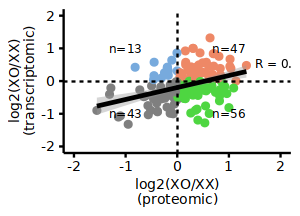

In [28]:
rna_protein_cor_plot

In [173]:
make_pdf(rna_protein_cor_plot, "rna_protein_cor_plot", w=3.5, h=1.8)

`geom_smooth()` using formula = 'y ~ x'


png 
  2

In [9]:
enrichment <- function(data){
    out <- list()
    df <- as.table(rbind(c(data[[1]], data[[2]]), c(data[[3]], data[[4]])))
    dimnames(df) <- list(genes = c("Upregulated genes", "X-linked genes"), test = c("Yes", "No"))
    out[[1]] <- fisher.test(df)
    out[[2]] <- chisq.test(df)
    out[[3]] <- as.data.table(df) %>% 
        dcast(genes~test) %>% 
        mutate(total=Yes+No, yes_perc=Yes/(Yes+No), no_perc=No/(Yes+No)) %>%
        select(genes, yes_perc, no_perc) %>%
        melt(id.vars = "genes", ) %>%
        select(-variable) %>%
        mutate(genes_factor=factor(.$genes, levels=c("X-linked genes", "Upregulated genes")))
    return(out)
}

enrichment_barplot <- function(df, title, lim){
    out <- ggplot(df, aes(x=genes_factor, 
                          fill=genes_factor,
                          y=value*100)) +
        geom_bar(stat="identity", color="black", width=0.8) +
        #facet_wrap(~genes_factor, strip.position="bottom", scales="free_x") +
        scale_fill_manual(values=c("#77AADB", "#ee8866")) +
        ggtitle(title) +
        ylab(NULL) +
        xlab(NULL) +
        coord_cartesian(clip="off") +
        scale_x_discrete(labels=c("Reference proteins", "Upregulated proteins")) +
        scale_y_continuous(labels = function(x){paste0(x, "%")}, expand=c(0,0), limits = c(0, lim)) +
        theme(panel.grid=element_blank(),
              panel.background=element_blank(),
              axis.title.y=element_text(color="black", size=7),
              axis.text.y=element_text(color="black", size=7),
              axis.text.x=element_text(color="black", size=7, margin=margin(t=0, b=0), angle=45, hjust=1),
              #axis.text.x=element_blank(),
              legend.title=element_text(size=7, hjust=0.5),
              axis.ticks=element_line(color="black"),
              axis.ticks.x=element_blank(),
              axis.line.x=element_line(color="black"),
              axis.line.y=element_line(color="black"),
              legend.text=element_text(size=7),
              legend.position="none",
              plot.title=element_text(size=7, hjust=0.5),
              strip.background = element_blank(),
              strip.placement = "outside",
              #strip.text.x = element_text(color="black", angle=90, size=7, hjust=1, vjust=0.5, margin=margin(t=0)),
              strip.text.x = element_blank(),
              panel.spacing = unit(0, "lines"))    
    return(out)
}       

Using 'N' as value column. Use 'value.var' to override



[[1]]

	Fisher's Exact Test for Count Data

data:  df
p-value = 0.03045
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 1.033221 5.486006
sample estimates:
odds ratio 
  2.408479 


[[2]]

	Pearson's Chi-squared test with Yates' continuity correction

data:  df
X-squared = 4.4218, df = 1, p-value = 0.03548


[[3]]
               genes     value      genes_factor
1: Upregulated genes 0.3111111 Upregulated genes
2:    X-linked genes 0.1572327    X-linked genes
3: Upregulated genes 0.6888889 Upregulated genes
4:    X-linked genes 0.8427673    X-linked genes


Warning message:
"Removed 2 rows containing missing values (`position_stack()`)."


ERROR: Error in (function (cond) : error in evaluating the argument 'x' in selecting a method for function 'as.table': subscript out of bounds


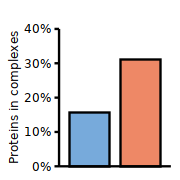

In [36]:
options(repr.plot.width=1.5, repr.plot.height=1.5)
protein_reference <- protein_data %>% filter(!GeneID %in% protein_up_genes) %>% .$GeneID
complex_forming_genes_symbol <- toupper(gene_metadata[which(gene_metadata$GENEID %in% complex_forming_genes),]$SYMBOL)
complex_protein_up <- enrichment(c(table(protein_up_genes %in% complex_forming_genes_symbol)[[2]],
                                 length(protein_up_genes) - table(protein_up_genes %in% complex_forming_genes_symbol)[[2]],
                                 table(protein_reference %in% complex_forming_genes)[[2]],
                                 length(protein_reference) - table(protein_reference %in% complex_forming_genes)[[2]]))
complex_protein_up
complex_protein_plot <- enrichment_barplot(as.data.frame(complex_protein_up[[3]]), "", 40) + ylab("Proteins in complexes") + theme(axis.text.x=element_blank())
complex_protein_plot

condens_protein_up <- enrichment(c(table(protein_up_genes %in% condensate_genes)[[2]],
                                 length(protein_up_genes) - table(protein_up_genes %in% condensate_genes)[[2]],
                                 table(protein_reference %in% condensate_genes)[[2]],
                                 length(protein_reference) - table(protein_reference %in% condensate_genes)[[2]]))
condens_protein_up
condens_protein_plot <- enrichment_barplot(as.data.frame(condens_protein_up[[3]]), "", 40) + ylab("Proteins which form condensates") + theme(axis.text.x=element_blank())
condens_protein_plot

In [39]:
make_pdf(complex_protein_plot, "complex_protein_plot", w=1.5, h=1.5)
make_pdf(condens_protein_plot, "condens_protein_plot", w=1.5, h=1.5)

Warning message:
"Removed 2 rows containing missing values (`position_stack()`)."


png 
  2